In [1]:
%%capture
!pip install timm
!pip install randaugment

In [2]:
import os
import timm
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from randaugment import RandAugment, ImageNetPolicy, Cutout
from collections import OrderedDict

import itertools
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [3]:
root_dir = '/kaggle/input/chest-xray-classification'
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        Cutout(size=16),
        RandAugment(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [4]:
batch_size = 32
image_datasets = {x : datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
data_loader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size if x!='test' else 2, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [5]:
print(dataset_sizes)
print(class_names)

{'train': 17813, 'val': 2227, 'test': 2229}
['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']


# Model

In [6]:
efficientnet_b2 = timm.create_model('efficientnet_b2')
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1408, 512)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(256, 5))
]))
efficientnet_b2.classifier = classifier
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b2.load_state_dict(torch.load('../input/cxr-weight/effnet_b2.pth'))

<All keys matched successfully>

In [7]:
swin_transformer = timm.create_model('swin_base_patch4_window7_224')
head = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(256, 5))
]))
swin_transformer.head = head
swin_transformer = swin_transformer.to(device)
swin_transformer.load_state_dict(torch.load('../input/cxr-weight/swin_transformer.pth'))

<All keys matched successfully>

# Ensemble

In [8]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        self.effnet_b2 = efficientnet_b2
        self.swin = swin_transformer
        
    def forward(self, x):
        x1 = self.effnet_b2(x)
        x2 = self.swin(x)
        x = sum([x1, x2])/2
        return x

model = Ensemble_Model().to(device)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Testing complete in 1m 40s
              precision    recall  f1-score   support

           0    0.99399   0.91436   0.95252       362
           1    0.95408   0.93189   0.94286       602
           2    0.93339   0.97830   0.95532      1060
           3    1.00000   0.91852   0.95753       135
           4    0.91781   0.95714   0.93706        70

    accuracy                        0.95110      2229
   macro avg    0.95986   0.94004   0.94906      2229
weighted avg    0.95237   0.95110   0.95106      2229



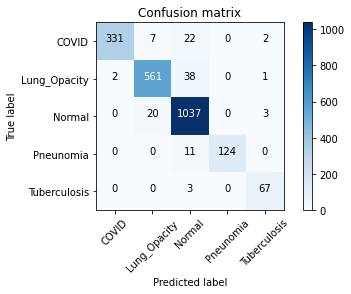

In [10]:
model.eval()
since = time.time()
y_test = []
y_pred = []
y_pred_proba = []
for images, labels in data_loader['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    y_pred_proba.append(outputs.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=5)
print(report)

In [11]:
def softmax(vec):
    exponential = np.exp(vec)
    probabilities = exponential / np.sum(exponential)
    return probabilities

y_pred_proba = np.array([list(softmax(i)) for i in y_pred_proba])

ROC curve (area = 0.9965)


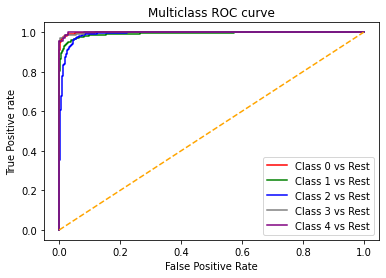

In [12]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print('ROC curve (area = %0.4f)' % roc_auc)
fpr = {}
tpr = {}
thresh ={}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], color='gray', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], color='purple', label='Class 4 vs Rest')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 